In [16]:
#importing libraries
import os
import gzip
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **Q2 Logistic Regression**

In [17]:
## Script 2 given in HW2

# One-hot encoding of the labels
def one_hot_encoding(label_data): # TODO: Write this function by yourself
    encoded_labels = np.zeros((len(label_data), 10)) 
    for i in range(len(label_data)):
        encoded_labels[i][label_data[i]] = 1
    return encoded_labels  

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    rows = normalized_pixels.shape[0]//784
    flattened_pixels = normalized_pixels.reshape(rows,784) # TODO: Flatten the normalized pixels
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("data/train-images-idx3-ubyte.gz")
    y_train = read_labels("data/train-labels-idx1-ubyte.gz")
    X_test = read_pixels("data/t10k-images-idx3-ubyte.gz")
    y_test = read_labels("data/t10k-labels-idx1-ubyte.gz")
    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = read_dataset()
X_val = X_train[:10000]
y_val = y_train[:10000]
X_train = X_train[10000:]
y_train = y_train[10000:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape



((50000, 784),
 (50000, 10),
 (10000, 784),
 (10000, 10),
 (10000, 784),
 (10000, 10))

In [18]:
class LogisticRegression():
    # Multinomial Logistic Regression Model written from scratch
    def __init__(self, seed=42):
        np.random.seed(seed)
        self.W = None
        self.now = None
        self.print_result = True
        self.history_steps1 = None
        self.history = None
        self.validation_accuracy = None
        
    def validation_accuracy(self):
        return self.validation_accuracy
    
    def history(self):
        return self.history
    
    def load_history(self):
        pd_hist = pd.read_csv(f'model-comparison/{self.now}/history.csv')
        self.history = np.array(pd_hist.iloc[:,1:])
        
    def plot(self, save = True):
        # Save history as csv file
        history_local = self.history
        if type(history_local) is not pd.DataFrame:
            history_df = pd.DataFrame(history_local)
        if save == True:
            hist_csv_file = f'model-comparison/{self.now}/history.csv'
            with open(hist_csv_file, mode='w') as f:
                history_df.to_csv(f) 
        # Plot Loss and Accuracy History as Subplots
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(10, 2)
        index = np.arange(1,self.history.shape[1]+1)*self.history_steps1

        ax[0].plot(index, self.history[0], label='Training Loss')
        ax[0].plot(index, self.history[2], label='Validation Loss')
        ax[0].set_title('Loss History')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        ax[1].plot(index, self.history[1], label='Training Accuracy')
        ax[1].plot(index, self.history[3], label='Validation Accuracy')
        ax[1].set_title('Accuracy History')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        if save is True and self.now is not None:
            plt.savefig(f'model-comparison/{self.now}/plot.png')
        if self.print_result == True:
            plt.show()
        else:
            plt.close(fig)
        
    
    def validation(self, X_nonbiased, y, W, lmbda):
        # add bias
        ones=np.ones(X_nonbiased.shape[0])
        X=np.c_[ones,X_nonbiased]
        # Find loss and accuracy on validation set
        y_onehot = y # y is already one-hot encoded
        Z = - X @ W
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        loss = - np.sum(y_onehot * np.log(P)) + lmbda * np.sum(W**2)
        y_pred = self.predict(X_nonbiased)
        accuracy = np.mean(y_pred == np.argmax(y, axis=1))
        return loss, accuracy
    
    def fit(self, X_nonbiased, y, X_val, y_val, now = None, print_result = True,max_epoch=400, batch_size=50000, weight_init='zero', lr=0.01, lr_type = 'static', regularization='l2: 0.01', save = True):
        start_time = datetime.datetime.now()
        # if there isn't model-comparison folder, create it
        if save == True:
            if not os.path.exists('model-comparison'):
                os.mkdir('model-comparison')
            self.print_result = print_result
            if now is not None:
                self.now = now
            # Create folder for current model
                if not os.path.exists('model-comparison/'+now):
                    os.mkdir('model-comparison/'+now)

        history_steps = 1
        self.history_steps1 = history_steps
        self.history = np.zeros((4,max_epoch//history_steps))
        y_onehot = y # y is already one-hot encoded
        lr_print = str(lr) + ' ' + lr_type
        model_specs = 'Logistic Regression | Batch Size: {} | Weight Init. {} | lr: {} | Regularization: {} | Max Epoch: {} |'.format(batch_size, weight_init, lr_print, regularization, max_epoch)
        
        # add bias
        ones=np.ones(X_nonbiased.shape[0])
        X=np.c_[ones,X_nonbiased]
        
        # Initialize weights ( shape = features x classes matrix )
        if weight_init == 'zero':
            self.W = np.zeros((X.shape[1], y_onehot.shape[1])) 
        elif weight_init == 'uniform':
            self.W = np.random.uniform(0, 1, (X.shape[1], y_onehot.shape[1]))
        elif weight_init == 'normal':
            self.W = np.random.normal(0, 1, (X.shape[1], y_onehot.shape[1]))
        
        # Print loss and accuracy every 100 iterations or every max_iter//10 iterations if max_iter >= 1000
        print_step = 10
        if max_epoch >= 1000:
            print_step = max_epoch // 10

        # Gradient Descent
        for epoch in range(1, max_epoch+1):
            for iteration in range(X.shape[0]//batch_size):                                        
                X_batch = X[batch_size*iteration:batch_size*(iteration+1)]
                y_batch = y_onehot[batch_size*iteration:batch_size*(iteration+1)]
                Z_batch = - X_batch @ self.W
                # For numerical stability
                ### Z_batch = Z_batch - np.max(Z_batch, axis=1, keepdims=True)
                # Logistic function to find probabilities
                P_batch = np.exp(Z_batch) / (np.sum(np.exp(Z_batch), axis=1, keepdims=True))
                # Number of X instances
                N = X_batch.shape[0]
                # Derivative of Residual ( log-loss )
                # P_batch = Softmax(- X_batch @ self.W)
                dRSS = (X_batch.T @ (y_batch - P_batch))
                # Choose regularization
                if regularization[0:2] == 'l2':
                    # L2 regularization
                    lmbda = float(regularization[4:])
                    dRegTerm = lmbda * self.W
                    # Bias term is not regularized
                    dRegTerm[0] *= 0
                    
                elif regularization[0:2] == 'l1':
                    # L1 regularization
                    lmbda = float(regularization[4:])
                    dRegTerm = lmbda * np.sign(self.W) 
                else:
                    # No regularization
                    lmbda = 0
                    dRegTerm = 0
                # Calculate gradient
                gradient = dRSS + dRegTerm
            
                if lr_type[0:8] == 'momentum':
                    if epoch == 1:
                        last_gradient = gradient
                    else:
                        momentum = float(lr_type[10:])
                        gradient = gradient + momentum * last_gradient
                        last_gradient = gradient
                    
                # Update weights 
                # ( W already has bias term, so we don't need seperate update, 
                # W is (features+1) x classes matrix: bias is in the first row 
                # and bias is not regularized ) W = 785 x 10
                self.W = self.W - lr * gradient
            
                # Change learning rate if lr_type is adaptive
                if lr_type == 'adaptive':
                    if epoch % 300 == 0:                    
                        lr = lr * 2
                        if print_result == True:
                            print('Learning rate changed to', lr)
            # After each epoch, calculate loss and accuracy on validation set
            Z = - X @ self.W
            # Numerical stability
            ### Z = Z - np.max(Z, axis=1, keepdims=True)
            P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

            # Calculate loss and accuracy every 1 epochs:
            if epoch % history_steps == 0:
                loss = - np.sum(y_onehot * np.log(P)) + lmbda * np.sum(self.W**2)
                accuracy = np.mean(self.predict(X_nonbiased) == np.argmax(y, axis=1))
                val_loss = self.validation(X_val, y_val, self.W, lmbda)[0]
                val_acc = self.validation(X_val, y_val, self.W, lmbda)[1]
                self.validation_accuracy = val_acc
                self.history[:,(epoch//history_steps)-1] = np.array([loss, accuracy, val_loss, val_acc])
                
                # Print loss and accuracy every 10 epochs
                if epoch % print_step == 0:
                    line1 = 'Epoch: ' + str(epoch)
                    line2 = ' | Accuracy: ' + str(accuracy)[0:5]
                    line3 = ' | Val. Acc: ' + str(val_acc)[0:5]
                    # line2 = ' | Loss: ' + str(round(loss)) + ' | Accuracy: ' + str(accuracy)[0:5]
                    # line3 = ' | Val. Loss: ' + str(round(val_loss)) + ' | Val. Acc: ' + str(val_acc)[0:5]
                    if print_result == True:
                        print(line1 + line2 + line3)
                    if save == True:
                        if now is not None:
                            with open('model-comparison/{}/log.txt'.format(now), 'a') as f:
                                f.write(line1 + line2 + line3 + '\n')
            if epoch == max_epoch:
                end_time = datetime.datetime.now()
                if print_result == True:
                    print('Training finished. Time elapsed:', end_time - start_time, '\n')
                    print('Accuracy: ', str(accuracy)[0:5], 'Val. Accuracy: ', str(val_acc)[0:5])
                val_acc_print = str(val_acc*100)+ '00'
                if save == True:
                    if now is not None:
                        with open('model-comparison/{}/log.txt'.format(now), 'a') as f:
                            write_line = 'Training finished. Time elapsed: ' + str(end_time - start_time) + '\n'
                            f.write(write_line)
                        with open('model-comparison/{}/{}-val-acc.txt'.format(now,val_acc_print[0:5]), 'w') as f:
                            f.write(model_specs)
                        with open('model-comparison/last.txt', 'w') as f:
                            f.write(str(now))
                
    def predict(self, X_nonbiased):
        # add bias
        ones=np.ones(X_nonbiased.shape[0])
        X=np.c_[ones,X_nonbiased]
        Z = - X @ self.W
        # Logistic function to find probabilities
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        # Predict class
        y = np.argmax(P, axis=1)
        return y
    def save_weights(self):
        filename = 'model-comparison/{}/weights.npy'.format(self.now)
        np.save(filename, self.W)
    def load_weights(self, now):
        filename = 'model-comparison/{}/weights.npy'.format(now)
        self.W = np.load(filename)
        self.now = now
    def return_weights(self):
        return self.W

In [19]:
class EvaluateModel():
    # Class to evaluate model performance, similar to sklearn.metrics ClassificationReport and ConfusionMatrix
    def __init__(self, y_true, y_pred, str1, now=None, save=True, print_result=True):
        self.y_true = np.argmax(y_true, axis=1)
        self.y_pred = y_pred
        if save == True:
            os.mkdir('model-comparison/'+now+'/'+str1)
            np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
        
        result = self.classification_report()
        fpr0 = 100 - float(result['precision'][0][0:4])
        line1 = 'Accuracy is: ' + str(result['f1-score']['accuracy'])
        line2 = 'F1 Score is: ' + str(result['f1-score']['weighted avg'])
        line3 = 'Precision of Class 0 is: ' + '{0:.2f}'.format(100-fpr0)+ ' %'
        line4 = '\nClassification Report:'
        line5 = '\nConfusion Matrix:'
        cm = self.confusion_matrix()
        line6 = '\n'
        res_total = line1 + '\n' + line2 + '\n' + line3 + '\n' + line4 + '\n' + str(result) + '\n' + line5 + '\n' + str(cm) + '\n' + line6
        # write to file
        if save == True:
            with open('model-comparison/{}/{}/report.txt'.format(now,str1), 'w') as f:
                f.write(res_total)
        if print_result == True:
            print(res_total)

    def accuracy_score(self, y_t, y_p):
        correct = sum(y_t == y_p)
        return correct / len(y_t)

    def scores(self, y_t, y_p, class_label= 1):
        true = y_t == class_label
        pred = y_p == class_label
        tp = sum(true & pred)
        fp = sum(~true & pred) 
        fn = sum(true & ~pred)
        tn = sum(~true & ~pred) 
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        f2 = (1+2**2) * (precision * recall) / ((2**2)*precision + recall)
        return precision, recall, f1, f2
    
    def confusion_matrix(self,labels=None):
        labels = labels if labels else sorted(set(self.y_true) | set(self.y_pred))        
        indexes = {v:i for i, v in enumerate(labels)}
        matrix = np.zeros((len(indexes),len(indexes))).astype(int)
        for t, p in zip(self.y_true, self.y_pred):
            matrix[indexes[t], indexes[p]] += 1
        # print('Confusion Matrix: ')
        # print(pd.DataFrame(matrix, index=labels, columns=labels))
        return pd.DataFrame(matrix, index=labels, columns=labels)

    def classification_report(self):
        output_dict = {}
        support_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        f2_list = []
        for i in np.unique(self.y_true):
            support = sum(self.y_true == i)
            precision, recall, f1, f2 = self.scores(self.y_true, self.y_pred, class_label=i)
            output_dict[i] = {'precision':precision, 'recall':recall, 'f1-score':f1, 'f2-score': f2, 'support':support}
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            f2_list.append(f2)
            support_list.append(support)
        support = np.sum(support_list)
        output_dict['accuracy'] = {'precision':0, 'recall':0, 'f1-score':self.accuracy_score(self.y_true, self.y_pred), 'f2-score':0, 'support':support}
        # macro avg
        macro_precision = np.mean(precision_list)
        macro_recall = np.mean(recall_list)
        macro_f1 = np.mean(f1_list)
        macro_f2 = np.mean(f2_list)
        output_dict['macro avg'] = {'precision':macro_precision, 'recall':macro_recall, 'f1-score':macro_f1, 'f2-score': macro_f2,'support':support}
        # weighted avg
        weighted_precision = np.average(precision_list, weights=support_list)
        weighted_recall = np.average(recall_list, weights=support_list)
        weighted_f1 = np.average(f1_list, weights=support_list)
        weighted_f2 = np.average(f2_list, weights=support_list)
        output_dict['weighted avg'] = {'precision':weighted_precision, 'recall':weighted_recall, 'f1-score':weighted_f1, 'f2-score': weighted_f2,'support':support}
        # convert to dataframe and format
        report_d = pd.DataFrame(output_dict).T
        annot = report_d.copy()
        annot.iloc[:, 0:4] = (annot.iloc[:, 0:4]*100).applymap('{:.2f}'.format) + ' %'
        annot['support'] = annot['support'].astype(int)
        annot.loc['accuracy','f2-score'] = ''
        annot.loc['accuracy','precision'] = ''
        annot.loc['accuracy','recall'] = ''
        return annot

Epoch: 10 | Accuracy: 0.852 | Val. Acc: 0.853
Epoch: 20 | Accuracy: 0.876 | Val. Acc: 0.877
Epoch: 30 | Accuracy: 0.887 | Val. Acc: 0.886
Epoch: 40 | Accuracy: 0.894 | Val. Acc: 0.893
Epoch: 50 | Accuracy: 0.898 | Val. Acc: 0.898
Epoch: 60 | Accuracy: 0.902 | Val. Acc: 0.900
Epoch: 70 | Accuracy: 0.906 | Val. Acc: 0.903
Epoch: 80 | Accuracy: 0.908 | Val. Acc: 0.904
Epoch: 90 | Accuracy: 0.910 | Val. Acc: 0.905
Epoch: 100 | Accuracy: 0.912 | Val. Acc: 0.907
Training finished. Time elapsed: 0:01:12.741687 

Accuracy:  0.912 Val. Accuracy:  0.907


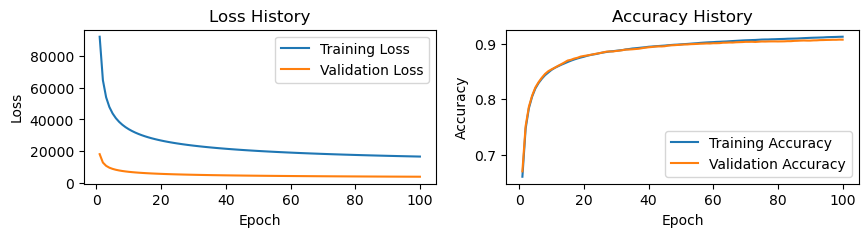

Accuracy is: 90.72 %
F1 Score is: 90.71 %
Precision of Class 0 is: 94.30 %

Classification Report:
             precision   recall f1-score f2-score  support
0              94.31 %  96.10 %  95.20 %  95.74 %     1001
1              94.72 %  95.47 %  95.10 %  95.32 %     1127
2              89.66 %  87.49 %  88.56 %  87.91 %      991
3              89.05 %  88.28 %  88.66 %  88.43 %     1032
4              91.15 %  91.43 %  91.29 %  91.37 %      980
5              84.50 %  86.56 %  85.52 %  86.14 %      863
6              92.49 %  93.49 %  92.99 %  93.29 %     1014
7              94.28 %  90.93 %  92.58 %  91.59 %     1070
8              89.05 %  84.43 %  86.68 %  85.31 %      944
9              86.47 %  91.51 %  88.92 %  90.46 %      978
accuracy                         90.72 %             10000
macro avg      90.57 %  90.57 %  90.55 %  90.56 %    10000
weighted avg   90.75 %  90.72 %  90.71 %  90.71 %    10000

Confusion Matrix:
     0     1    2    3    4    5    6    7    8    9
0  

In [20]:
# Train Default model
model = LogisticRegression(seed=42)
model.fit(X_train, y_train, X_val, y_val, now=None, max_epoch=100, save=False,
          batch_size=200, weight_init='normal', lr=0.0005, lr_type='static', regularization='l2: 0.0001')
model.plot(save=False)

# Validation Set Results
y_pred = model.predict(X_val)
results = EvaluateModel(y_val, y_pred, 'val', now=None, save=False)

# Test Set Results
y_pred = model.predict(X_test)
results = EvaluateModel(y_test, y_pred, 'test', now=None, save=False)

Epoch: 10 | Accuracy: 0.918 | Val. Acc: 0.917
Epoch: 20 | Accuracy: 0.923 | Val. Acc: 0.92
Epoch: 30 | Accuracy: 0.926 | Val. Acc: 0.922
Epoch: 40 | Accuracy: 0.927 | Val. Acc: 0.922
Epoch: 50 | Accuracy: 0.928 | Val. Acc: 0.922
Epoch: 60 | Accuracy: 0.929 | Val. Acc: 0.922
Epoch: 70 | Accuracy: 0.929 | Val. Acc: 0.922
Epoch: 80 | Accuracy: 0.930 | Val. Acc: 0.923
Epoch: 90 | Accuracy: 0.930 | Val. Acc: 0.923
Epoch: 100 | Accuracy: 0.931 | Val. Acc: 0.923
Training finished. Time elapsed: 0:03:11.435925 

Accuracy:  0.931 Val. Accuracy:  0.923


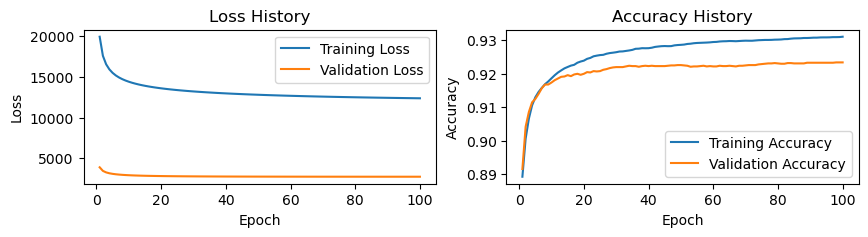

Accuracy is: 92.34 %
F1 Score is: 92.32 %
Precision of Class 0 is: 95.30 %

Classification Report:
             precision   recall f1-score f2-score  support
0              95.33 %  97.80 %  96.55 %  97.30 %     1001
1              94.57 %  97.34 %  95.93 %  96.77 %     1127
2              92.56 %  89.10 %  90.80 %  89.77 %      991
3              90.97 %  88.86 %  89.90 %  89.27 %     1032
4              93.05 %  92.96 %  93.01 %  92.98 %      980
5              87.85 %  89.69 %  88.76 %  89.31 %      863
6              94.80 %  95.36 %  95.08 %  95.25 %     1014
7              94.97 %  91.78 %  93.35 %  92.40 %     1070
8              91.01 %  85.81 %  88.33 %  86.80 %      944
9              87.30 %  93.46 %  90.27 %  92.16 %      978
accuracy                         92.34 %             10000
macro avg      92.24 %  92.21 %  92.20 %  92.20 %    10000
weighted avg   92.37 %  92.34 %  92.32 %  92.33 %    10000

Confusion Matrix:
     0     1    2    3    4    5    6    7    8    9
0  

In [23]:
# Train Best model
model = LogisticRegression(seed=42)
model.fit(X_train, y_train, X_val, y_val, now=None, max_epoch=100, save=False,
          batch_size=1, weight_init='zero', lr=0.001, lr_type='static', regularization='l2: 0.0001')
model.plot(save=False)

best_weights = model.return_weights()

# Validation Set Results
y_pred = model.predict(X_val)
results = EvaluateModel(y_val, y_pred, 'val', now=None, save=False)

# Test Set Results
y_pred = model.predict(X_test)
results = EvaluateModel(y_test, y_pred, 'test', now=None, save=False)

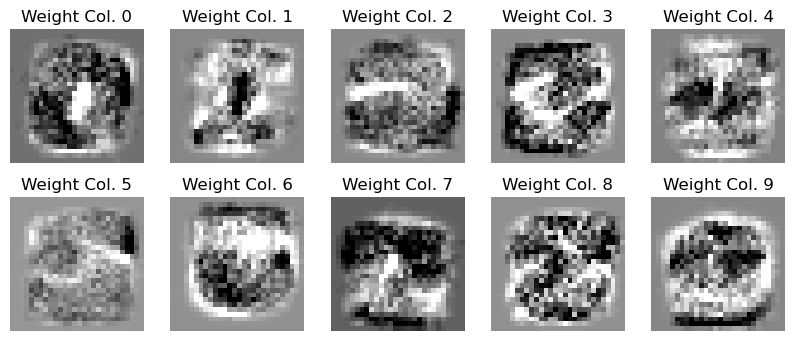

In [24]:
# Print Weights
best_weights = best_weights[1:] # Remove bias from weight matrix
plt.subplots(2, 5 ,figsize=(10, 4))
for i in range(best_weights.shape[1]):
    col = best_weights[:,i]
    reconstructed_col = col.reshape(28,28)
    plt.subplot(2, 5, i+1)
    plt.imshow(reconstructed_col, cmap=plt.cm.gray, vmin=0.5*reconstructed_col.min(), vmax=0.5*reconstructed_col.max())
    # plt.matshow is not working for subplots, so I used plt.imshow instead
    # plt.matshow(reconstructed_col, cmap=plt.cm.gray, vmin=0.5*reconstructed_col.min(), vmax=0.5*reconstructed_col.max())
    plt.title(f'Weight Col. {i}')
    plt.axis('off')
plt.show()